In [1]:
import pandas as pd 
from sklearn.externals import joblib
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df_week = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/I1.csv")

In [3]:
def get_teams(df):
    
    teams = []
    
    for i,cal in enumerate(df.iterrows()):
        teams.append(cal[1]["HomeTeam"])
        teams.append(cal[1]["AwayTeam"])

        if i == 9: 
            return teams


In [4]:
teams_1617 = get_teams(df_week)

print teams_1617

['Juventus', 'Fiorentina', 'Roma', 'Udinese', 'Atalanta', 'Lazio', 'Bologna', 'Crotone', 'Chievo', 'Inter', 'Empoli', 'Sampdoria', 'Genoa', 'Cagliari', 'Milan', 'Torino', 'Palermo', 'Sassuolo', 'Pescara', 'Napoli']


In [5]:
def build_features(df, teams):

    team_features = []
    
    for team in teams:
        #print team_a
        team_home = df[df['HomeTeam']==team]
        team_away = df[df['AwayTeam']==team]
        
        #shots made
        team_s    = team_away["AS"].sum()  + team_home["HS"].sum()
        #shots on-target made
        team_st   = team_away["AST"].sum() + team_home["HST"].sum()
        #shots conceded
        team_sc    = team_away["HS"].sum()  + team_home["AS"].sum()
        #shots on-target conceded
        team_stc   = team_away["HST"].sum() + team_home["AST"].sum()
        #corners awarded
        team_c    = team_away["AC"].sum()  + team_home["HC"].sum()
        #corners conceded
        team_cc    = team_away["HC"].sum()  + team_home["AC"].sum()

        team_features.append([team_s,team_sc,team_st,team_stc,team_c,team_cc])

    return team_features

In [6]:
def build_target(df, teams):

    team_target = []
    
    for team in teams:
        #print team_a
        t      = df[(df['HomeTeam']==team) | (df['AwayTeam']==team)]
        team_home = df[df['HomeTeam']==team]
        team_away = df[df['AwayTeam']==team]

        team_h_win = len(team_home[team_home['FTHG']>team_home['FTAG']])
        team_a_win = len(team_away[team_away['FTAG']>team_away['FTHG']])
        team_draw = len(t[t['FTAG']==t['FTHG']])

        team_points = 3*team_a_win + 3*team_h_win + team_draw
        team_target.append(team_points)

    return team_target


In [7]:
targ_1617 = build_target(df_week, teams_1617)
feat_1617 = build_features(df_week, teams_1617)

In [8]:
model_1 = joblib.load('../data/linreg_model.pkl')

pred_1617 = model_1.predict(feat_1617)

In [9]:
#print pred_1617
#print teams_1617
ranking  = []
realrank = []

for t,p,tg in zip(teams_1617,pred_1617,targ_1617):
    ranking.append((t, p, tg))
    
for t,p in zip(teams_1617,targ_1617):
    realrank.append((t, p))
    

In [10]:
ranking.sort(key=lambda x: x[2],reverse=True)
teams_pred_real = []

for t,p,tg in ranking:
    print t,'{:.1f}'.format(p),'{:.0f}'.format(tg), '{:.1f}'.format(tg-p)
    teams_pred_real.append((t,'{:.1f}'.format(p),'{:.1f}'.format(tg)))
    

Juventus 16.5 18 1.5
Napoli 13.2 14 0.8
Roma 15.6 13 -2.6
Lazio 10.4 13 2.6
Chievo 8.2 13 4.8
Milan 9.3 13 3.7
Inter 12.6 11 -1.6
Genoa 10.0 11 1.0
Torino 13.8 11 -2.8
Bologna 8.1 10 1.9
Cagliari 7.1 10 2.9
Atalanta 8.9 9 0.1
Sassuolo 8.4 9 0.6
Fiorentina 7.3 8 0.7
Udinese 7.4 7 -0.4
Sampdoria 10.5 7 -3.5
Palermo 3.9 6 2.1
Pescara 8.4 6 -2.4
Empoli 6.1 4 -2.1
Crotone 5.7 1 -4.7


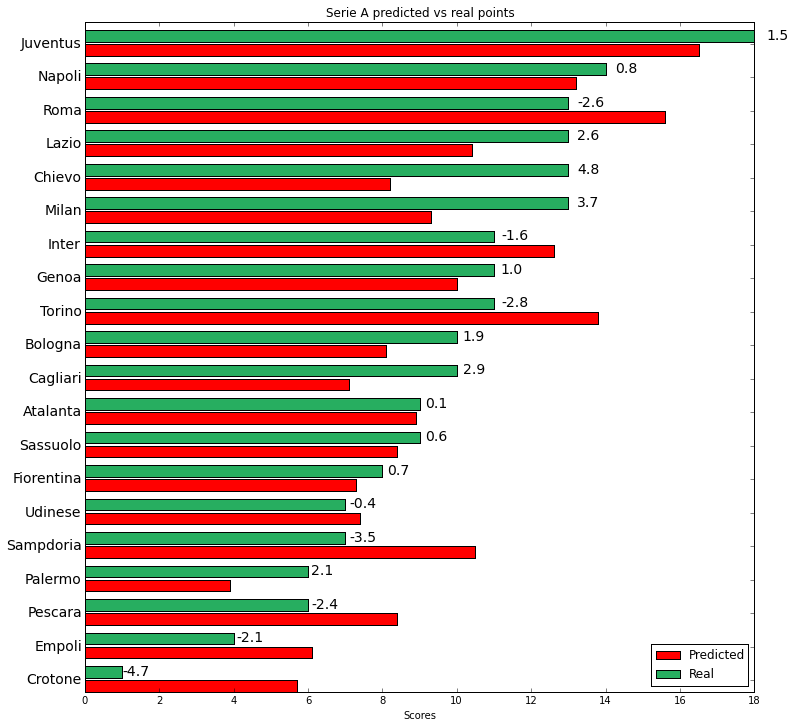

In [11]:
#!/usr/bin/env python

team_names = [x[0] for x in teams_pred_real]
team_pred =  [float(x[1]) for x in teams_pred_real]
team_real =  [float(x[2]) for x in teams_pred_real]

team_names.reverse()
team_pred.reverse()
team_real.reverse()

width = 0.35       # the width of the bars
space = 0.07       # the space bw the bars

n = 20
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(12, 12))

rects1 = ax.barh(ind, team_pred, width, color='r')
rects2 = ax.barh(ind + width + space, team_real, width, color='#27AE60')

# add some text for labels, title and axes ticks
ax.set_xlabel('Scores')
ax.set_title('Serie A predicted vs real points')
ax.set_yticks(ind + width)
ax.set_yticklabels(team_names,size=14,family='sans-serif')

ax.legend((rects1[0], rects2[0]), ('Predicted', 'Real'), loc=4)


def autolabel(rects):
    # attach some text labels
    for t,p,rect in zip(team_real,team_pred,rects):
        width = rect.get_width()
        ax.text(1.02*width, rect.get_y() + rect.get_height()/0.9, 
                '%.1f' % float(t-p),
                ha='left', va='top', size=14)

#autolabel(rects1)
autolabel(rects2)

plt.savefig("serieA.pdf")
plt.show()


In [12]:
with open('../data/16-17/pred.csv', 'wb') as csvfile:
    predwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    predwriter.writerow(['team','prediction','points','difference'])
    for t,p,tg in ranking:
        print t,'{:.1f}'.format(p),'{:.0f}'.format(tg), '{:.1f}'.format(tg-p)
        predwriter.writerow([t,'{:.1f}'.format(p),'{:.0f}'.format(tg), '{:.1f}'.format(tg-p)])

Juventus 16.5 18 1.5
Napoli 13.2 14 0.8
Roma 15.6 13 -2.6
Lazio 10.4 13 2.6
Chievo 8.2 13 4.8
Milan 9.3 13 3.7
Inter 12.6 11 -1.6
Genoa 10.0 11 1.0
Torino 13.8 11 -2.8
Bologna 8.1 10 1.9
Cagliari 7.1 10 2.9
Atalanta 8.9 9 0.1
Sassuolo 8.4 9 0.6
Fiorentina 7.3 8 0.7
Udinese 7.4 7 -0.4
Sampdoria 10.5 7 -3.5
Palermo 3.9 6 2.1
Pescara 8.4 6 -2.4
Empoli 6.1 4 -2.1
Crotone 5.7 1 -4.7


In [11]:
print targ_1617
print model_1.predict(feat_1617)
#Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_1.score(feat_1617, targ_1617))
print("Residual sum of squares: %.2f"
      % np.mean((model_1.predict(feat_1617) - targ_1617) ** 2))

[15, 8, 10, 7, 6, 10, 10, 1, 10, 11, 4, 6, 8, 7, 10, 8, 5, 9, 6, 14]
[ 13.28814816   5.85363566  13.23133664   6.07288054   7.74749192
   8.62696283   7.49107787   3.66096048   6.44601939  11.14159122
   5.95732209   7.85538915   8.65434676   5.39490759   7.77242939
  11.94548183   3.61764554   7.67638765   7.47042555  12.11945368]
Variance score: 0.55
Residual sum of squares: 4.50


In [12]:
model_1 = joblib.load('../data/regtree_model.pkl')

pred_1617 = model_1.predict(feat_1617)

In [26]:
print pred_1617
print targ_1617

[ 7.5620905   2.80125714  9.25664294  3.50680177  4.26056926  5.6904567
  5.45391209  2.21995481  5.31535688  7.3547763   4.11077132  5.32366018
  6.21354512  4.84450966  4.5698418   8.40492037  2.87155497  5.74984379
  4.35735024  9.34533022]
[9, 6, 7, 6, 3, 7, 6, 1, 7, 7, 4, 6, 6, 4, 6, 4, 2, 9, 1, 10]
